In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


In [2]:
greater_melbourne = pd.read_csv("../data/curated/greater_melbourne.csv")
rest_of_vic = pd.read_csv("../data/curated/rest_of_vic.csv")

In [3]:
greater_melbourne.head()

,beds,baths,parking,dist_to_city,dist_to_education,dist_to_parks_and_gardens,dist_to_train_station,dist_to_healthcare,weekly_cost,num_homeless_persons,...,median_age,median_weekly_rent,percent_aboriginal_torres_strait_islander,percent_au_citizen,percent_overseas_born,percent_rental_properties,population,percent_unemployed,housing_index,cpi_without_housing
0,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,680.0,34.666667,...,42.46,509.8,0.313333,4.393333,35.14,43.72,14208.250639,4.573333,145.288421,127.830132
1,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,775.0,34.666667,...,42.46,509.8,0.313333,4.393333,35.14,43.72,14208.250639,4.573333,145.288421,127.830132
2,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,775.0,34.666667,...,42.12,506.7,0.303333,4.673333,34.76,43.58,13106.132992,4.543333,141.520263,125.573860
3,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,680.0,34.666667,...,41.44,500.5,0.283333,5.233333,34.00,43.30,12696.762148,4.483333,133.983947,121.061316
4,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,675.0,34.666667,...,41.44,500.5,0.283333,5.233333,34.00,43.30,12696.762148,4.483333,133.983947,121.061316


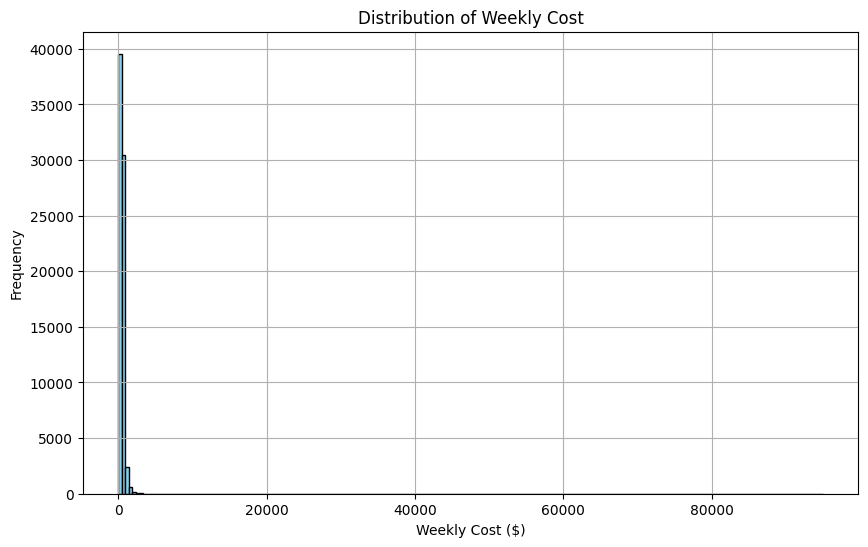

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(greater_melbourne['weekly_cost'], bins=200, color='skyblue', edgecolor='black')
plt.title('Distribution of Weekly Cost')
plt.xlabel('Weekly Cost ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

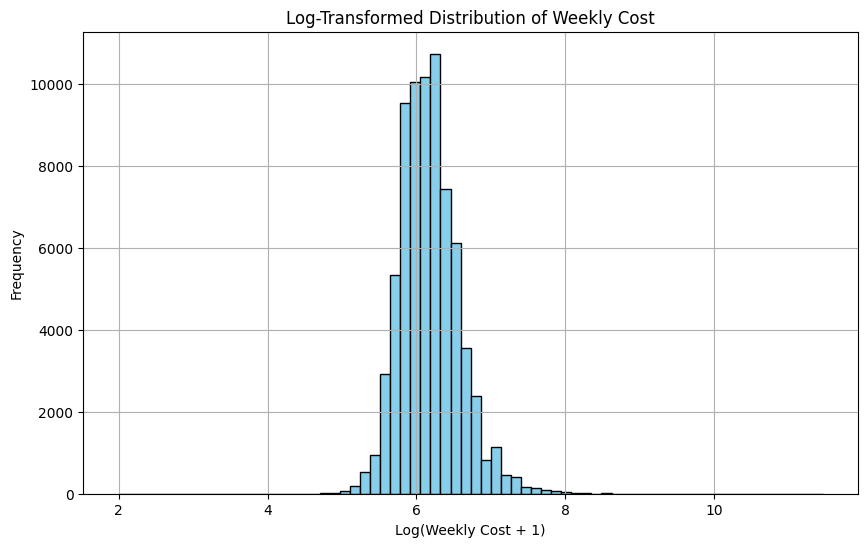

In [5]:
# Log transformation of the 'weekly_cost' column
log_weekly_cost = np.log1p(greater_melbourne['weekly_cost'])

# Plot the log-transformed distribution
plt.figure(figsize=(10, 6))
plt.hist(log_weekly_cost, bins=70, color='skyblue', edgecolor='black')
plt.title('Log-Transformed Distribution of Weekly Cost')
plt.xlabel('Log(Weekly Cost + 1)')
plt.ylabel('Frequency')
plt.grid(True)

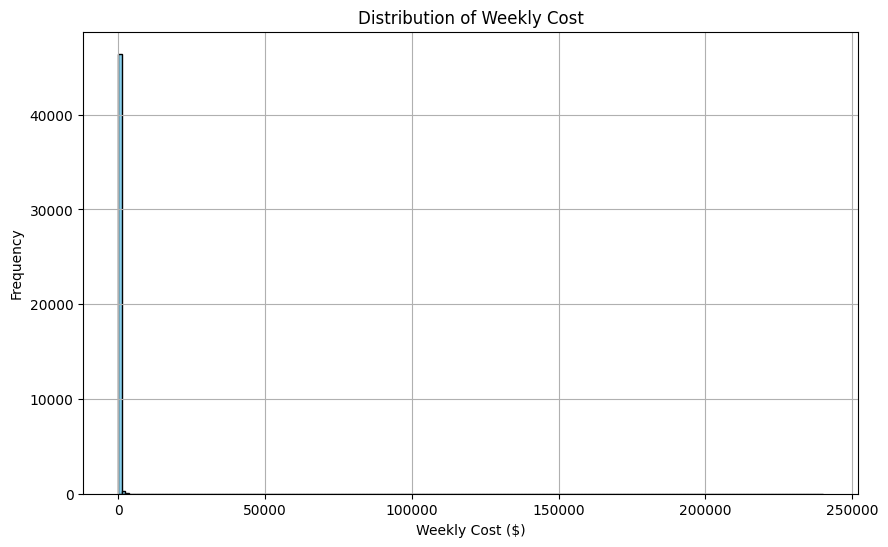

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(rest_of_vic['weekly_cost'], bins=200, color='skyblue', edgecolor='black')
plt.title('Distribution of Weekly Cost')
plt.xlabel('Weekly Cost ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

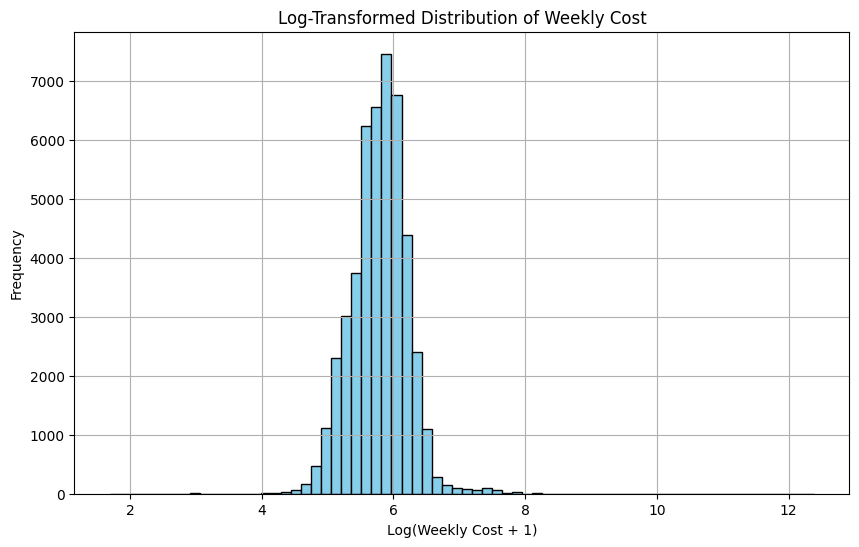

In [7]:
# Log transformation of the 'weekly_cost' column
log_weekly_cost = np.log1p(rest_of_vic['weekly_cost'])

# Plot the log-transformed distribution
plt.figure(figsize=(10, 6))
plt.hist(log_weekly_cost, bins=70, color='skyblue', edgecolor='black')
plt.title('Log-Transformed Distribution of Weekly Cost')
plt.xlabel('Log(Weekly Cost + 1)')
plt.ylabel('Frequency')
plt.grid(True)

In [8]:
X_gm = greater_melbourne.drop(columns=['weekly_cost'])  # assuming 'weekly_cost' is the target
y_gm_log = np.log1p(greater_melbourne['weekly_cost'])
scaler = StandardScaler()
X_gm_scaled = scaler.fit_transform(X_gm)


In [9]:
X_rov = rest_of_vic.drop(columns=['weekly_cost'])  # assuming 'weekly_cost' is the target
y_rov_log = np.log1p(rest_of_vic['weekly_cost'])
X_rov_scaled = scaler.fit_transform(X_rov)

In [10]:
# Split the dataset
X_train_gm, X_test_gm, y_train_gm, y_test_gm = train_test_split(X_gm_scaled, y_gm_log, test_size=0.2, random_state=42)

In [11]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_gm, y_train_gm)

# Predictions and evaluation
y_pred_lr_gm = lr_model.predict(X_test_gm)
print('Linear Regression MSE:', mean_squared_error(y_test_gm, y_pred_lr_gm))

# Coefficients (feature importance for Linear Regression)
importance_lr = lr_model.coef_
for i, v in enumerate(importance_lr):
    print(f'Feature {i}: {v:.4f}')

Linear Regression MSE: 0.048283292964801904
Feature 0: 0.1656
Feature 1: 0.0927
Feature 2: 0.0211
Feature 3: -0.0053
Feature 4: 0.0128
Feature 5: 0.0037
Feature 6: -0.0047
Feature 7: 0.0177
Feature 8: -0.0032
Feature 9: -0.0573
Feature 10: 0.0182
Feature 11: 0.0190
Feature 12: 0.0518
Feature 13: 0.1016
Feature 14: -0.0489
Feature 15: 0.0043
Feature 16: -0.0360
Feature 17: 0.1020
Feature 18: 0.1159
Feature 19: -0.0057
Feature 20: 376485461706.3942
Feature 21: -376485461706.4238


In [13]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_gm, y_train_gm)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test_gm)
print('Random Forest MSE:', mean_squared_error(y_test_gm, y_pred_rf))

# Feature importance for Random Forest
importance_rf = rf_model.feature_importances_
for i, v in enumerate(importance_rf):
    print(f'Feature {i}: {v:.4f}')

Random Forest MSE: 0.022991487754904855
Feature 0: 0.0849
Feature 1: 0.2017
Feature 2: 0.0142
Feature 3: 0.0612
Feature 4: 0.0291
Feature 5: 0.0270
Feature 6: 0.0300
Feature 7: 0.0275
Feature 8: 0.0087
Feature 9: 0.0557
Feature 10: 0.0151
Feature 11: 0.0149
Feature 12: 0.0200
Feature 13: 0.3009
Feature 14: 0.0143
Feature 15: 0.0100
Feature 16: 0.0111
Feature 17: 0.0118
Feature 18: 0.0158
Feature 19: 0.0129
Feature 20: 0.0160
Feature 21: 0.0172
